See code at https://github.com/google-research/vision_transformer/

See paper at https://arxiv.org/abs/2010.11929

This Colab allows you to run the [JAX](https://jax.readthedocs.org) implementation of the Vision Transformer.

##### Copyright 2020 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/vision_transformer/blob/master/vit_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

Needs to be executed once in every VM.

The cell below downloads the code from Github and install necessary dependencies.

In [ ]:
#@markdown Select whether you would like to store data in your personal drive.
#@markdown
#@markdown If you select **yes**, you will need to authorize Colab to access
#@markdown your personal drive
#@markdown
#@markdown If you select **no**, then any changes you make will diappear when
#@markdown this Colab's VM restarts after some time of inactivity...
use_gdrive = 'yes'  #@param ["yes", "no"]
account = "shikhartuli98@gmail.com" #@param ["shikhartuli98@gmail.com", "stuli@princeton.edu"]

if use_gdrive == 'yes':
  from google.colab import drive
  drive.mount('/gdrive')
  if account == "shikhartuli98@gmail.com":
    root = '/gdrive/My Drive/cnn_txf_bias/vision_transformer'
  else:
    root = '/gdrive/My Drive/Fall 20-21/COS 454/Project/cnn_txf_bias/vision_transformer'
  import os
  if not os.path.isdir(root):
    os.mkdir(root)
  os.chdir(root)
  print(f'\nChanged CWD to "{root}"')
else:
  from IPython import display
  display.display(display.HTML(
      '<h1 style="color:red">CHANGES NOT PERSISTED</h1>'))

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).

Changed CWD to "/gdrive/My Drive/cnn_txf_bias/vision_transformer"


In [ ]:
!pip install -qr ./vit_jax/requirements_new.txt
!pip install tfa-nightly
!pip install tensorflow_io
!pip install tfds-nightly

     |████████████████████████████████| 61kB 2.5MB/s 
     |████████████████████████████████| 153kB 9.4MB/s 
     |████████████████████████████████| 92kB 7.0MB/s 
     |████████████████████████████████| 144.5MB 78kB/s 
     |████████████████████████████████| 4.3MB 38.0MB/s 
     |████████████████████████████████| 706kB 4.8MB/s 
     |████████████████████████████████| 25.3MB 188kB/s 
     |████████████████████████████████| 3.7MB 5.4MB/s 


In [ ]:
#@markdown TPU setup : Boilerplate for connecting JAX to TPU.

import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  # Make sure the Colab Runtime is set to Accelerator: TPU.
  import requests
  if 'TPU_DRIVER_MODE' not in globals():
    url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver0.1-dev20191206'
    resp = requests.post(url)
    TPU_DRIVER_MODE = 1

  # The following is required to use TPU Driver as JAX's backend.
  from jax.config import config
  config.FLAGS.jax_xla_backend = "tpu_driver"
  config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
  print('Registered TPU:', config.FLAGS.jax_backend_target)
else:
  print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

Registered TPU: grpc://10.26.44.50:8470


### Imports

In [ ]:
# Specify model.
model = 'ViT-B_32'

In [ ]:
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
import flax.jax_utils as flax_utils
import random
import cv2
import csv
import re
import os
import tensorflow_io as tfio

# Shows the number of available devices.
# In a CPU/GPU runtime this will be a single device.
# In a TPU runtime this will be 8 cores.
jax.local_devices()

[TpuDevice(id=0, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=2, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=3, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=4, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=5, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=6, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=7, host_id=0, coords=(0,0,0), core_on_chip=0)]

In [ ]:
# Import files from repository.
# Updating the files in the editor on the right will immediately update the
# modules by re-importing them.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

# Adding simclr directory to path
sys.path.append('../simclr/')

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from vit_jax import checkpoint
from vit_jax import hyper
from vit_jax import input_pipeline
from vit_jax import logging
from vit_jax import models
from vit_jax import momentum_clip
from vit_jax import train

# Importing data-augmentation functions
import data_util

logger = logging.setup_logger('./logs')

In [ ]:
# Helper functions for images.

labelnames = dict(
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar100=('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'),
  imagenet2012=tuple(open('ilsvrc2012_wordnet_lemmas.txt'))
)
def make_label_getter(dataset):
  """Returns a function converting label indices to names."""
  def getter(label):
    if dataset in labelnames:
      return labelnames[dataset][label]
    return f'label={label}'
  return getter

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)

### Load dataset

In [ ]:
dataset = 'imagenet2012'
batch_size = 512  # Reduce to 256 if running on a single GPU.

In [ ]:
# Note the datasets are configured in input_pipeline.DATASET_PRESETS
# Have a look in the editor at the right.
num_classes = 1000 # input_pipeline.get_dataset_info(dataset, 'train')['num_classes']
    # tf.data.Datset for training, infinite repeats.
ds_train = input_pipeline.get_data(
    dataset=dataset, mode='test', repeats=1, batch_size=batch_size, 
    # tfds_manual_dir = '/scratch/network/stuli/datasets/imagenet2012',
    tfds_data_dir = './tensorflow_datasets_subset'
)
    # tf.data.Datset for evaluation, single repeat.
ds_test = input_pipeline.get_data(
    dataset=dataset, mode='test', repeats=1, batch_size=batch_size, 
    # tfds_manual_dir = '/scratch/network/stuli/datasets/imagenet2012',
    tfds_data_dir = './tensorflow_datasets_subset'
)

2021-01-02 08:21:35,061 [INFO] absl: Load dataset info from ./tensorflow_datasets_subset/imagenet2012/5.1.0
2021-01-02 08:21:36,755 [INFO] absl: Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: imagenet2012/5.1.0
2021-01-02 08:21:37,158 [INFO] absl: Load dataset info from /tmp/tmps1rru538tfds
2021-01-02 08:21:37,180 [INFO] absl: Field info.description from disk and from code do not match. Keeping the one from code.
2021-01-02 08:21:37,187 [INFO] absl: Field info.module_name from disk and from code do not match. Keeping the one from code.
2021-01-02 08:21:37,201 [INFO] absl: Reusing dataset imagenet2012 (./tensorflow_datasets_subset/imagenet2012/5.1.0)
2021-01-02 08:21:37,207 [INFO] absl: Constructing tf.data.Dataset for split validation[:], from ./tensorflow_datasets_subset/imagenet2012/5.1.0
2021-01-02 08:21:38,632 [INFO] absl: Load dataset info from ./tensorflow_datasets_subset/imagenet2012/5.1.0
2021-01-02 08:21:38,659 [INFO] absl: Load pre-computed DatasetInfo

In [ ]:
# Fetch a batch of test images for illustration purposes.
batch = next(iter(ds_test.as_numpy_iterator()))
# Note the shape : [num_local_devices, local_batch_size, h, w, c]
batch['image'].shape

(8, 64, 384, 384, 3)

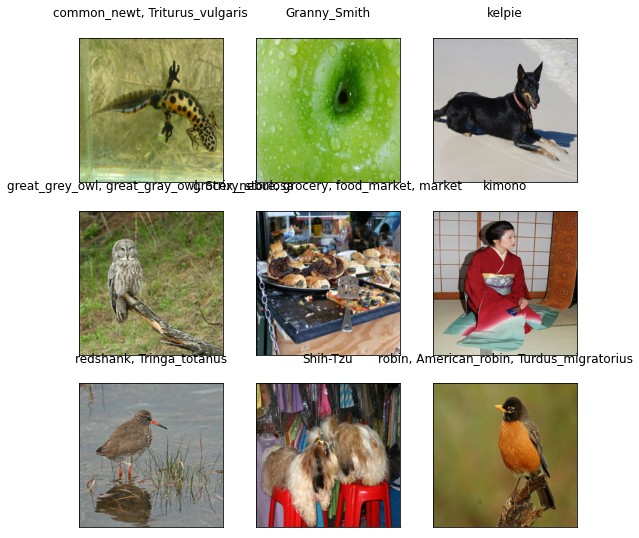

In [ ]:
# Show some imags with their labels.
# images, labels = tfa.image.cutout_ops.random_cutout(batch['image'][0][:9], tuple([np.int32(0.5*x) for x in batch['image'][0][0].shape[:2]])), batch['label'][0][:9]
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

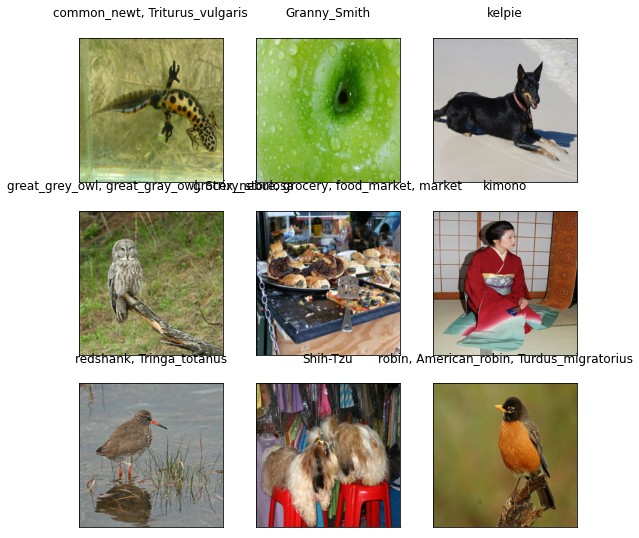

In [ ]:
# Same as above, but with train images.
# Do you spot a difference?
# Check out input_pipeline.get_data() in the editor at your right to see how the
# images are preprocessed differently.
batch = next(iter(ds_train.as_numpy_iterator()))
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

### Load pre-trained

In [ ]:
# Load model definition & initialize random parameters.
VisionTransformer = models.KNOWN_MODELS[model].partial(num_classes=num_classes)
_, params = VisionTransformer.init_by_shape(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    [(batch['image'].shape[1:], batch['image'].dtype.name)])

models_done = len(os.listdir('./vit_models/imagenet21k+imagenet2012+imagenet2012/'))

experiments = ['Baseline', 'Rotate', 'Cutout', 'Sobel Filtering', 'Gaussian Blur', 'Color Distortion', 'Gaussain Noise']

if models_done > 1:
  exp_done = 'Baseline'
  for i in range(models_done-1):
    exp_done = f'{exp_done}+{experiments[i+1]}'
  params = checkpoint.load(f'./vit_models/imagenet21k+imagenet2012+imagenet2012/{model}_{exp_done}.npz')
  params['pre_logits'] = {}
else:
  params = checkpoint.load(f'./vit_models/imagenet21k+imagenet2012/{model}.npz')
  params['pre_logits'] = {}

In [ ]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.

# params = checkpoint.load(f'./vit_models/imagenet21k+imagenet2012/{model}.npz')
# params['pre_logits'] = {} 

# params = checkpoint.load_pretrained(
#     pretrained_path=f'./vit_models/imagenet21k+imagenet2012/{model}.npz',
#     init_params=params,
#     model_config=models.CONFIGS[model],
#     logger=logger,
# )

### Evaluate

In [ ]:
# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['cls']).__name__, params['cls'].shape)
print('params_repl.cls:', type(params_repl['cls']).__name__, params_repl['cls'].shape)

params.cls: ndarray (1, 1, 768)
params_repl.cls: ShardedDeviceArray (8, 1, 1, 768)


In [ ]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(VisionTransformer.call)

In [ ]:
def get_accuracy(params_repl):
  """Returns accuracy evaluated on the test set."""
  good = total = 0
  steps = input_pipeline.get_dataset_info(dataset, 'test')['num_examples'] // batch_size
  for _, batch in zip(tqdm.notebook.trange(steps), ds_test.as_numpy_iterator()):
    predicted = vit_apply_repl(params_repl, batch['image'])
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total

In [ ]:
# Random performance without fine-tuning.
get_accuracy(params_repl)

2020-12-31 11:28:24,112 [INFO] absl: Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: imagenet2012/5.1.0
2020-12-31 11:28:24,438 [INFO] absl: Load dataset info from /tmp/tmp6ieay9mitfds
2020-12-31 11:28:24,448 [INFO] absl: Field info.description from disk and from code do not match. Keeping the one from code.
2020-12-31 11:28:24,454 [INFO] absl: Field info.module_name from disk and from code do not match. Keeping the one from code.


DeviceArray(0.81284225, dtype=float32)

### Fine-tune

In [ ]:
# 100 Steps take approximately 15 minutes in the TPU runtime.
total_steps = 50
warmup_steps = 5
decay_type = 'cosine'
grad_norm_clip = 1
# This controls in how many forward passes the batch is split. 8 works well with
# a TPU runtime that has 8 devices. 64 should work on a GPU. You can of course
# also adjust the batch_size above, but that would require you to adjust the
# learning rate accordingly.
accum_steps = 8
base_lr = 0.03

In [ ]:
# Check out train.make_update_fn in the editor on the right side for details.
update_fn_repl = train.make_update_fn(VisionTransformer.call, accum_steps)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
opt = momentum_clip.Optimizer(grad_norm_clip=grad_norm_clip).create(params)
opt_repl = flax.jax_utils.replicate(opt)

In [ ]:
lr_fn = hyper.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
# Prefetch entire learning rate schedule onto devices. Otherwise we would have
# a slow transfer from host to devices in every step.
lr_iter = hyper.lr_prefetch_iter(lr_fn, 0, total_steps)
# Initialize PRNGs for dropout.
update_rngs = jax.random.split(jax.random.PRNGKey(0), jax.local_device_count())

In [ ]:
airplane_indices = [404]
bear_indices = [294, 295, 296, 297]
bicycle_indices = [444, 671]
bird_indices = [8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 22, 23,
                24, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92, 93,
                94, 95, 96, 98, 99, 100, 127, 128, 129, 130, 131,
                132, 133, 135, 136, 137, 138, 139, 140, 141, 142,
                143, 144, 145]
boat_indices = [472, 554, 625, 814, 914]
bottle_indices = [440, 720, 737, 898, 899, 901, 907]
car_indices = [436, 511, 817]
cat_indices = [281, 282, 283, 284, 285, 286]
chair_indices = [423, 559, 765, 857]
clock_indices = [409, 530, 892]
dog_indices = [152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
                162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
                172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
                182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
                193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
                203, 205, 206, 207, 208, 209, 210, 211, 212, 213,
                214, 215, 216, 217, 218, 219, 220, 221, 222, 223,
                224, 225, 226, 228, 229, 230, 231, 232, 233, 234,
                235, 236, 237, 238, 239, 240, 241, 243, 244, 245,
                246, 247, 248, 249, 250, 252, 253, 254, 255, 256,
                257, 259, 261, 262, 263, 265, 266, 267, 268]
elephant_indices = [385, 386] 
keyboard_indices = [508, 878]
knife_indices = [499]
oven_indices = [766]
truck_indices = [555, 569, 656, 675, 717, 734, 864, 867]

category_indices = [airplane_indices, bear_indices, bicycle_indices, bird_indices, boat_indices,
                    bottle_indices, car_indices, cat_indices, chair_indices, clock_indices,
                    dog_indices, elephant_indices, keyboard_indices, knife_indices,
                    oven_indices, truck_indices]

In [ ]:
# Training with data-augmentation

tf.compat.v1.enable_eager_execution

experiments = ['Baseline', 'Rotate', 'Cutout', 'Sobel Filtering', 'Gaussian Blur', 'Color Distortion', 'Gaussain Noise']

# categories_cifar10 = ['airplane', 'automobile', 'bird', 'cat', 'dog', 'ship', 'truck']
# categories_SIN = ['airplane', 'car', 'bird', 'cat', 'dog', 'boat', 'truck']

categories = os.listdir("./stimuli/cue-conflict/")
categories.sort()

acc_imagenet = []
shape_match = []
texture_match = []
shape_bias = []

# Calculating total images in SIN-subset
total_images = 0
for c in categories:
  for im in os.listdir("./stimuli/cue-conflict/" + c):
    shape_label = c
    texture_label = re.search('-(.*).png', im).group(1)[:-1]
    total_images += 1

for exp in range(models_done - 1 if models_done > 1 else 0, len(experiments)):
  print(f'Running Experiment: {experiments[exp]}')

  lr_iter = hyper.lr_prefetch_iter(lr_fn, 0, total_steps)
  update_rngs = jax.random.split(jax.random.PRNGKey(0), jax.local_device_count())

  # if exp == 0:
  #   # Training loop
  #   for step, batch, lr_repl in zip(tqdm.notebook.trange(1, total_steps + 1), ds_train.as_numpy_iterator(), lr_iter):
  #     opt_repl, loss_repl, update_rngs = update_fn_repl(opt_repl, lr_repl, batch, update_rngs)

  if exp == 1:
    # Training loop
    for step, batch, lr_repl in zip(tqdm.notebook.trange(1, total_steps + 1), ds_train.as_numpy_iterator(), lr_iter):
      images, labels = batch['image'], batch['label']
      for i in range(images.shape[0]):
        bi = tf.image.rot90(images[i], random.randint(1, 3))
        images[i] = bi.numpy()
      batch_new = {'image': images, 'label': labels}
      opt_repl, loss_repl, update_rngs = update_fn_repl(opt_repl, lr_repl, batch_new, update_rngs)

  if exp == 2:
    # Training loop
    for step, batch, lr_repl in zip(tqdm.notebook.trange(1, total_steps + 1), ds_train.as_numpy_iterator(), lr_iter):
      images, labels = batch['image'], batch['label']
      for i in range(images.shape[0]):
        bi = tfa.image.cutout_ops.random_cutout(images[i], tuple([np.int32(random.randrange(2, 192, 2)), np.int32(random.randrange(2, 192, 2))]))
        images[i] = bi.numpy()
      batch_new = {'image': images, 'label': labels}
      opt_repl, loss_repl, update_rngs = update_fn_repl(opt_repl, lr_repl, batch_new, update_rngs)

  if exp == 3:
    # Training loop
    for step, batch, lr_repl in zip(tqdm.notebook.trange(1, total_steps + 1), ds_train.as_numpy_iterator(), lr_iter):
      images, labels = batch['image'], batch['label']
      for i in range(images.shape[0]):
        bi = tfio.experimental.filter.sobel(images[i])
        images[i] = bi.numpy()
      batch_new = {'image': images, 'label': labels}
      opt_repl, loss_repl, update_rngs = update_fn_repl(opt_repl, lr_repl, batch_new, update_rngs)
  
  if exp == 4:
    # Training loop
    for step, batch, lr_repl in zip(tqdm.notebook.trange(1, total_steps + 1), ds_train.as_numpy_iterator(), lr_iter):
      images, labels = batch['image'], batch['label']
      for i in range(images.shape[0]):
        bi = tfa.image.gaussian_filter2d(images[i]) #, filter_shape = [30, 30], sigma = 5)
        images[i] = bi.numpy()
      batch_new = {'image': images, 'label': labels}
      opt_repl, loss_repl, update_rngs = update_fn_repl(opt_repl, lr_repl, batch_new, update_rngs)

  if exp == 5:
    # Training loop
    for step, batch, lr_repl in zip(tqdm.notebook.trange(1, total_steps + 1), ds_train.as_numpy_iterator(), lr_iter):
      images, labels = batch['image'], batch['label']
      for i in range(images.shape[0]):
        bi = data_util.random_color_jitter(images[i])
        images[i] = bi
      batch_new = {'image': images, 'label': labels}
      opt_repl, loss_repl, update_rngs = update_fn_repl(opt_repl, lr_repl, batch_new, update_rngs)

  if exp == 6:
    # Training loop
    for step, batch, lr_repl in zip(tqdm.notebook.trange(1, total_steps + 1), ds_train.as_numpy_iterator(), lr_iter):
      images, labels = batch['image'], batch['label']
      for i in range(images.shape[0]):
        bi = tf.clip_by_value(images[i] + tf.random.normal(shape=tf.shape(images[i]), mean=0.0, stddev=(50)/(255), dtype=tf.float32), 0.0, 1.0)
        images[i] = bi.numpy()
      batch_new = {'image': images, 'label': labels}
      opt_repl, loss_repl, update_rngs = update_fn_repl(opt_repl, lr_repl, batch_new, update_rngs)

  exp_done = 'Baseline'
  for i in range(exp):
    exp_done = f'{exp_done}+{experiments[i+1]}'
  
  # Save model
  checkpoint.save(flax_utils.unreplicate(opt_repl.target), f'./vit_models/imagenet21k+imagenet2012+imagenet2012/{model}_{exp_done}.npz')

  # Accuracy on ImageNet
  print('Testing model on ImageNet')
  acc_imagenet.append(np.float(get_accuracy(opt_repl.target)))
  print(f'Accuracy = {acc_imagenet[-1]}')

  VisionTransformer = models.KNOWN_MODELS[model].partial(num_classes=num_classes)
  _, params = VisionTransformer.init_by_shape(jax.random.PRNGKey(0), [((1, 384, 384, 3), batch['image'].dtype.name)])
  params = checkpoint.load(f'./vit_models/imagenet21k+imagenet2012+imagenet2012/{model}_{exp_done}.npz')
  params['pre_logits'] = {}

  count = 0

  # SIN Test
  print('Running SIN Test')
  SIN_count = 0.0
  SIN_correct_shape = 0.0
  SIN_correct_texture = 0.0
  for c in categories:
    for im in os.listdir("./stimuli/cue-conflict/" + c + "/"):

      shape_label = c
      texture_label = re.search('-(.*).png', im).group(1)[:-1]

      img = cv2.imread("./stimuli/cue-conflict/" + c + "/" + im)
      img = cv2.resize(img, (384, 384))
      inp = (np.array(img) / 128 - 1)[None, ...]

      logits, = VisionTransformer.call(params, inp)
      preds = flax.nn.softmax(logits)

      # pred = preds.argsort()[-1]
      # pred_label = labelnames[dataset][pred]

      preds_16 = np.zeros(16)
      for idx in range(1000):
        for ci in range(len(category_indices)):
          if idx in category_indices[ci]:
            preds_16[ci] += preds[idx]

      try:
        SIN_correct_shape += 1 if (categories[preds_16.argsort()[-1]] == shape_label) else 0
      except:
        pass
      try:
        SIN_correct_texture += 1 if (categories[preds_16.argsort()[-1]] == texture_label) else 0
      except:
        pass

      SIN_count += 1

      count += 1
      print('\r %0.2f%%' % (count/(total_images)*100), end='')
  
  print()
  
  shape_match.append(SIN_correct_shape / SIN_count)
  texture_match.append(SIN_correct_texture / SIN_count)
  shape_bias.append(shape_match[-1] / (texture_match[-1] + shape_match[-1]))

  with open(f'./results/fine-tune/imagenet2012/vit_fine-tune.csv', mode='a') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    if exp == 0: csv_writer.writerow(['Augmentation', 'Shape Bias', 'Shape Match', 'Texture Match', 'ImageNet Accuracy'])
    aug = experiments[exp] if exp == 0 else f'+{experiments[exp]}'
    csv_writer.writerow([aug, f'{shape_bias[-1]*100}%', f'{shape_match[-1]*100}%', f'{texture_match[-1]*100}%', f'{acc_imagenet[-1]*100}%'])


Running Experiment: Cutout



Testing model on ImageNet


2021-01-02 08:40:18,494 [INFO] absl: Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: imagenet2012/5.1.0
2021-01-02 08:40:19,047 [INFO] absl: Load dataset info from /tmp/tmp4npunxi2tfds
2021-01-02 08:40:19,072 [INFO] absl: Field info.description from disk and from code do not match. Keeping the one from code.
2021-01-02 08:40:19,076 [INFO] absl: Field info.module_name from disk and from code do not match. Keeping the one from code.



Accuracy = 0.8265745639801025
Running SIN Test
 11.64%